In [1]:
import koreanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.tree as tree

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 데이터 불러오기

df = pd.read_csv('../data/BankChurners.csv')
df.drop('CLIENTNUM', axis=1, inplace=True)
df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis=1, inplace=True)
df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis=1, inplace=True)

In [3]:
# 컬럼 이름 변경
df.rename(columns={
    'Attrition_Flag' : 'Exited',
    'Customer_Age' : 'Age',
    'Dependent_count' : 'Dependents',
    'Education_Level' : 'Education', 
    'Marital_Status' : 'Marital', 
    'Income_Category' : 'Income', 
    'Card_Category' : 'Card_type',
    'Months_on_book' : 'Tenure', 
    'Total_Relationship_Count' : 'Product_Cnt', 
    'Months_Inactive_12_mon' : 'Inactive_Months',
    'Contacts_Count_12_mon' : 'Contacts_Cnt', 
    'Total_Revolving_Bal' : 'Revolv_Bal',   
    'Avg_Open_To_Buy' : 'Avg_OTB', 
    'Total_Amt_Chng_Q4_Q1' : 'Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt' : 'Trans_Amt',
    'Total_Trans_Ct' : 'Trans_Cnt', 
    'Total_Ct_Chng_Q4_Q1' : 'Cnt_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio' : 'Avg_Util_Ratio'
}, inplace=True)

In [4]:
# 컬럼 순서변경
df = df[['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital', 'Income', 'Card_type', 'Tenure', 'Product_Cnt', 'Inactive_Months',
         'Contacts_Cnt', 'Credit_Limit', 'Revolv_Bal', 'Avg_OTB', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1',  'Cnt_Chng_Q4_Q1']]

In [5]:
df.head()

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,0.061,1144,42,1.335,1.625
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,0.105,1291,33,1.541,3.714
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,0.000,1887,20,2.594,2.333
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,0.760,1171,20,1.405,2.333
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,0.000,816,28,2.175,2.500


In [6]:
df.tail()

,Exited,Age,Gender,Dependents,Education,Marital,Income,Card_type,Tenure,Product_Cnt,Inactive_Months,Contacts_Cnt,Credit_Limit,Revolv_Bal,Avg_OTB,Avg_Util_Ratio,Trans_Amt,Trans_Cnt,Amt_Chng_Q4_Q1,Cnt_Chng_Q4_Q1
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.462,15476,117,0.703,0.857
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.511,8764,69,0.804,0.683
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.000,10291,60,0.819,0.818
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.000,8395,62,0.535,0.722
10126,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.0,1961,8427.0,0.189,10294,61,0.703,0.649


## 1. Label Encoder

In [7]:
# ‘Exited’: 유지 0, 이탈 1 encoding
exited_mapping = {
    "Existing Customer" : 0,
    "Attrited Customer" : 1, }

le = LabelEncoder()
df['Exited'] = le.fit_transform(df['Exited'])
df['Exited'] = df['Exited'].map({le.transform([k])[0]: v for k, v in exited_mapping.items()})


In [8]:
# ‘Gender’: 남자 0, 여자 1 encoding
gender_mapping = {
    "M" : 0,
    "F" : 1, }

df['Gender'] = le.fit_transform(df['Gender'])
df['Gender'] = df['Gender'].map({le.transform([k])[0]: v for k, v in gender_mapping.items()})

In [9]:
# ‘Education’: unedu 0, high 1, col 2, gradu 3, post 4, doc 5, unknown 6 encoding
education_mapping = {
    'Uneducated' : 0, 
    'High School' : 1,
    'College' : 2,
    'Graduate' : 3, 
    'Post-Graduate' : 4,
    'Doctorate' : 5,
    'Unknown' : 6 
    }

df['Education'] = le.fit_transform(df['Education'])
df['Education'] = df['Education'].map({le.transform([k])[0]: v for k, v in education_mapping.items()})

In [10]:
# ‘Marital’: single 0, married 1, divorce 2, unknown 3 encoding

marital_mapping = {
    'Single' : 0, 
    'Married' : 1,
    'Divorced' : 2,
    'Unknown' : 3
    }

df['Marital'] = le.fit_transform(df['Marital'])
df['Marital'] = df['Marital'].map({le.transform([k])[0]: v for k, v in marital_mapping.items()})

In [11]:
# ‘Income’: less40 0, 40~60 1, 60~80 2, 80~120 3, 120+ 4, unknown 5 encoding

income_mapping = {
    'Less than $40K' : 0, 
    '$40K - $60K' : 1,
    '$60K - $80K' : 2,
    '$80K - $120K' : 3,
    '$120K +' : 4,
    'Unknown' : 5
    }

df['Income'] = le.fit_transform(df['Income'])
df['Income'] = df['Income'].map({le.transform([k])[0]: v for k, v in income_mapping.items()})

In [12]:
# ‘Card_type’: blue 0, silver 1, gold 2, platinum 3 encoding

card_mapping = {
    'Blue' : 0, 
    'Silver' : 1,
    'Gold' : 2,
    'Platinum' : 3,
    }

df['Card_type'] = le.fit_transform(df['Card_type'])
df['Card_type'] = df['Card_type'].map({le.transform([k])[0]: v for k, v in card_mapping.items()})

> ### 상관계수 확인

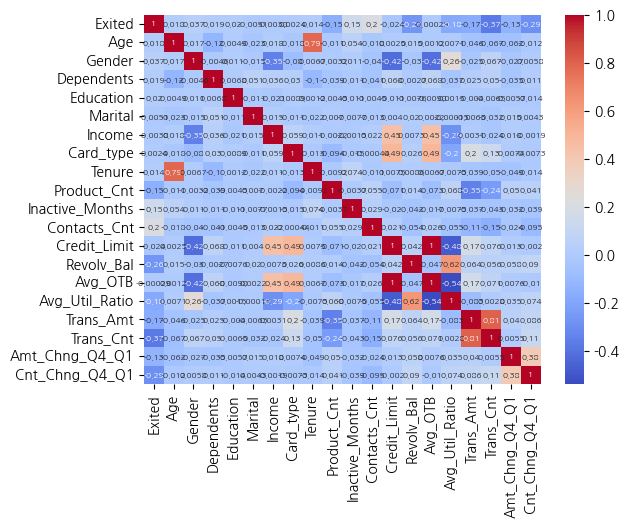

In [13]:
corr_df = df.corr()
sns.heatmap(corr_df, annot=True, cmap='coolwarm', annot_kws={'size':6});

## 2. Logistic Regression

> ### 2-1. liblinear
- L1제약조건, L2제약조건 두가지 모두 지원하며, 작은 데이터에 적합한 알고리즘

In [14]:
# 라벨 분류
X = df.drop(['Exited'], axis=1)
y = df['Exited']

# 훈련용 / 테스트용 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13) 

# Logistic Regression (solver='liblinear')
lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train, y_train)

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

coefficients = lr.coef_[0]
intercept = lr.intercept_[0]

print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
print('Test Acc : ', accuracy_score(y_test, y_pred_test))
print(f"절편: {intercept}")
print("회귀 계수")

feature_list = []
coef_list = []
for feature, coef in zip(X.columns, coefficients):
    feature_list.append(feature)
    coef_list.append(coef)
    # print(f"{feature}: {coef}")

coef_df = pd.DataFrame({
    'feature' : feature_list,
    'coef' : coef_list
})
coef_df['coef_abs'] = abs(coef_df['coef'])
coef_df.sort_values('coef_abs', ascending=False)

Train Acc :  0.8959387729909888
Test Acc :  0.8928923988153998
절편: 0.2682119961649087
회귀 계수


,feature,coef,coef_abs
18,Cnt_Chng_Q4_Q1,-0.775841,0.775841
1,Gender,0.651220,0.651220
10,Contacts_Cnt,0.609573,0.609573
9,Inactive_Months,0.563874,0.563874
8,Product_Cnt,-0.382497,0.382497
2,Dependents,0.233959,0.233959
17,Amt_Chng_Q4_Q1,-0.233312,0.233312
6,Card_type,0.223580,0.223580
16,Trans_Cnt,-0.101992,0.101992
4,Marital,-0.099700,0.099700


- 회귀계수 양수는 Gender, Contacts_Cnt, Inactive_Months, Dependents, Card_type
- 회귀계수 음수는 Cnt_Chng_Q4_Q1, Product_Cnt, Amt_Chng_Q4_Q1, Trans_Cnt, Marital
- 회귀계수 절대값 크기 Cnt_Chng_Q4_Q1, Gender, Contacts_Cnt, Inactive_Months, Product_Cnt, Dependents, Amt_Chng_Q4_Q1

> ### 그래프로 확인

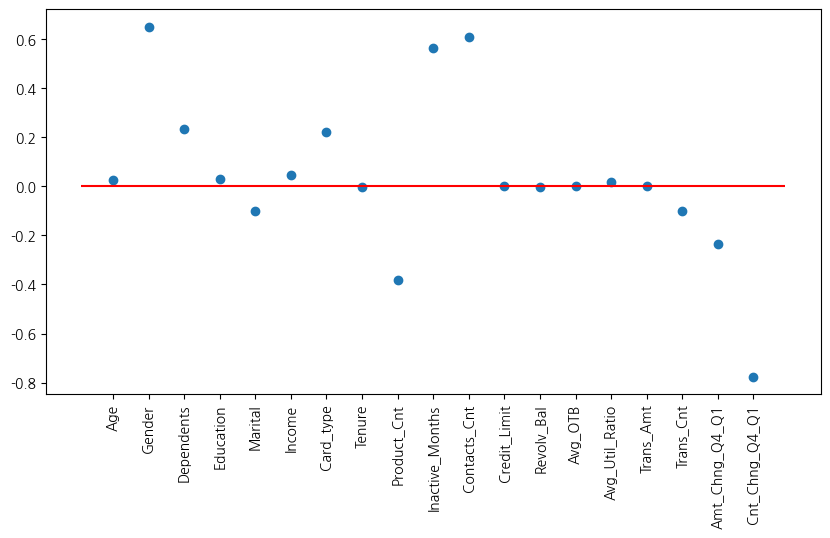

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(coef_df['feature'], coef_df['coef'])
plt.xticks(rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1], 'r')
plt.show();

In [16]:
feature_importance = lr.coef_[0]

# 피처 이름과 중요도를 매칭해서 출력
for feature, importance in zip(X.columns, feature_importance):
    print(f'{feature}: {importance}')

Age: 0.026065376236370404
Gender: 0.6512201513728167
Dependents: 0.23395875737762462
Education: 0.029170645639892183
Marital: -0.09969999968652156
Income: 0.04771584415107484
Card_type: 0.22357957139960935
Tenure: -0.0009878333642322267
Product_Cnt: -0.382497323178919
Inactive_Months: 0.5638737822083586
Contacts_Cnt: 0.6095733588560803
Credit_Limit: -0.0003010143441728695
Revolv_Bal: -0.0006018836761422394
Avg_OTB: 0.00030086919806414765
Avg_Util_Ratio: 0.019301729397254996
Trans_Amt: 0.00040775379825449116
Trans_Cnt: -0.10199232360527818
Amt_Chng_Q4_Q1: -0.2333120678151156
Cnt_Chng_Q4_Q1: -0.7758405485112266


## 검증

> ### KFold

#### KFold - MinMaxScaler

In [17]:

# 라벨 분류
X = df.drop(['Exited'], axis=1)
y = df['Exited']

kfold = KFold(n_splits=5, shuffle=True, random_state=13)
lr = LogisticRegression(solver='liblinear', random_state=13)

cv_accuracy = []
coefficients = []

for train_idx, test_idx in kfold.split(X):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    mms = MinMaxScaler()
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)

    lr.fit(X_train_scaled, y_train)
    pred = lr.predict(X_test_scaled)
    cv_accuracy.append(accuracy_score(y_test, pred))

    coefficients.append(lr.coef_[0])

print('KFold accuracy : ', cv_accuracy)
print('Average of accuracy : ', np.mean(cv_accuracy))

mean_coefficients = np.mean(coefficients, axis=0)

# 각 특성의 회귀 계수를 출력합니다.
print("Logistic Regression Coefficients:")

feature_list = []
coef_list = []

for feature, importance in zip(X.columns, mean_coefficients):
    feature_list.append(feature)
    coef_list.append(importance)

coef_df = pd.DataFrame({
    'feature' : feature_list,
    'coef' : coef_list
})
coef_df.sort_values('coef')

KFold accuracy :  [0.8993089832181639, 0.9057255676209279, 0.9041975308641975, 0.9032098765432098, 0.8987654320987655]
Average of accuracy :  0.9022414780690529
Logistic Regression Coefficients:


,feature,coef
16,Trans_Cnt,-11.209639
18,Cnt_Chng_Q4_Q1,-6.931200
8,Product_Cnt,-2.118473
12,Revolv_Bal,-2.109401
17,Amt_Chng_Q4_Q1,-1.464119
14,Avg_Util_Ratio,-0.236914
7,Tenure,-0.233178
11,Credit_Limit,-0.230250
4,Marital,-0.193758
0,Age,-0.113783


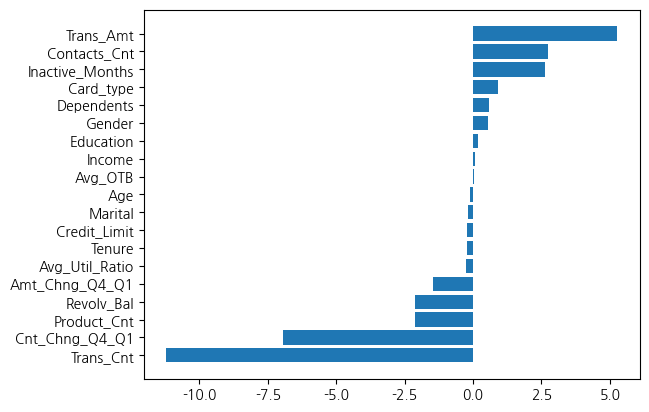

In [18]:
plt.barh(coef_df.sort_values('coef')['feature'], coef_df.sort_values('coef')['coef'])
plt.show();

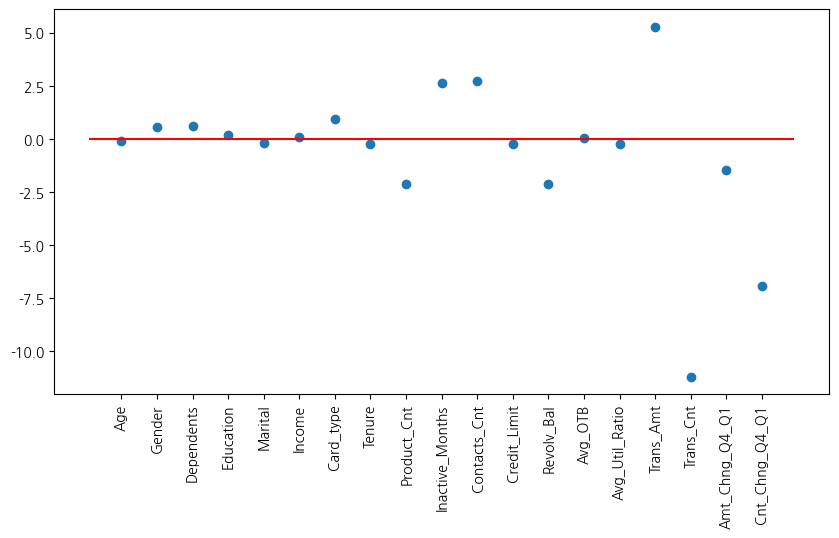

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(coef_df['feature'], coef_df['coef'])
plt.xticks(rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1], 'r')
plt.show();

---

#### KFold - StandardScaler

In [20]:
# 라벨 분류
X = df.drop(['Exited'], axis=1)
y = df['Exited']

kfold = KFold(n_splits=5, shuffle=True, random_state=13)
lr = LogisticRegression(solver='liblinear', random_state=13)

cv_accuracy = []
coefficients = []

for train_idx, test_idx in kfold.split(X):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    lr.fit(X_train_scaled, y_train)
    pred = lr.predict(X_test_scaled)
    cv_accuracy.append(accuracy_score(y_test, pred))

    coefficients.append(lr.coef_[0])

print('KFold accuracy : ', cv_accuracy)
print('Average of accuracy : ', np.mean(cv_accuracy))

mean_coefficients = np.mean(coefficients, axis=0)

# 각 특성의 회귀 계수를 출력합니다.
print("Logistic Regression Coefficients:")

feature_list = []
coef_list = []

for feature, importance in zip(X.columns, mean_coefficients):
    feature_list.append(feature)
    coef_list.append(importance)

coef_df = pd.DataFrame({
    'feature' : feature_list,
    'coef' : coef_list
})
coef_df.sort_values('coef')

KFold accuracy :  [0.8993089832181639, 0.9067127344521224, 0.9076543209876543, 0.9017283950617284, 0.9017283950617284]
Average of accuracy :  0.9034265657562794
Logistic Regression Coefficients:


,feature,coef
16,Trans_Cnt,-2.655014
12,Revolv_Bal,-0.768979
8,Product_Cnt,-0.697759
18,Cnt_Chng_Q4_Q1,-0.662231
17,Amt_Chng_Q4_Q1,-0.097300
4,Marital,-0.076445
11,Credit_Limit,-0.071148
7,Tenure,-0.048105
0,Age,-0.043193
14,Avg_Util_Ratio,-0.029521


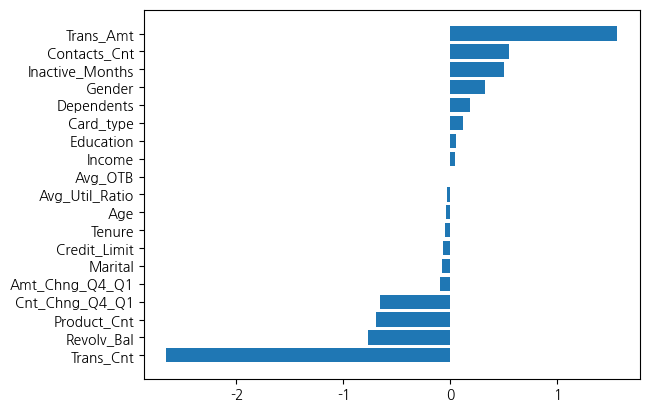

In [21]:
plt.barh(coef_df.sort_values('coef')['feature'], coef_df.sort_values('coef')['coef'])
plt.show();

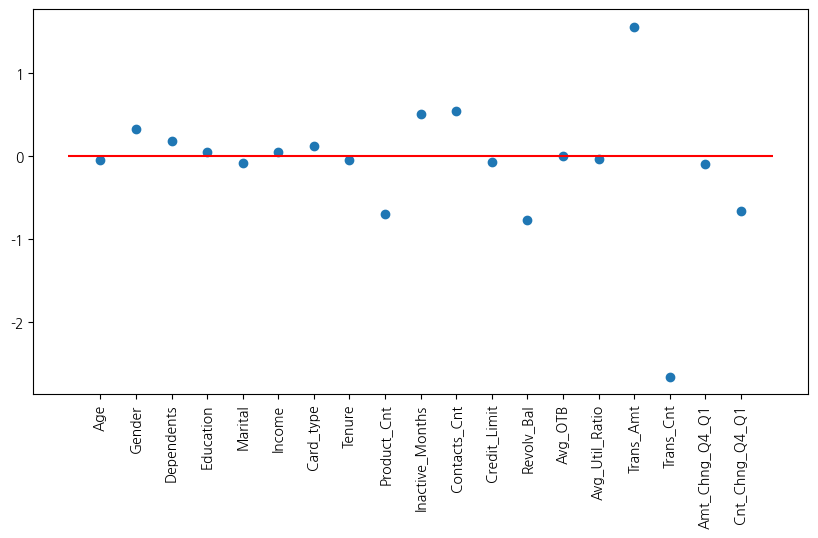

In [22]:
plt.figure(figsize=(10, 5))
plt.scatter(coef_df['feature'], coef_df['coef'])
plt.xticks(rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1], 'r')
plt.show();

- Product_Cnt / Inactive_Months / Contacts_Cnt / Revolv_Bal / Trans_Amt / Trans_Cnt / Cnt_Chng_Q4_Q1

---

> ### 2-2. StratifiedKFold

In [23]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
lr = LogisticRegression(solver='liblinear', random_state=13)

cv_accuracy = []
coefficients = []

for train_idx, test_idx in skfold.split(X, y):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    sc = StandardScaler()

    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    lr.fit(X_train_scaled, y_train)
    pred = lr.predict(X_test_scaled)
    cv_accuracy.append(accuracy_score(y_test, pred))

    coefficients.append(lr.coef_[0])

print('StratifiedKFold accuracy : ', cv_accuracy)
print('Average of accuracy : ', np.mean(cv_accuracy))

mean_coefficients = np.mean(coefficients, axis=0)

# 각 특성의 회귀 계수를 출력합니다.
print("Logistic Regression Coefficients:")

feature_list = []
coef_list = []

for feature, importance in zip(X.columns, np.abs(mean_coefficients)):
    feature_list.append(feature)
    coef_list.append(importance)

coef_df = pd.DataFrame({
    'feature' : feature_list,
    'coef' : coef_list
})
coef_df.sort_values('coef', ascending=False)

StratifiedKFold accuracy :  [0.9052319842053307, 0.9032576505429417, 0.9012345679012346, 0.9076543209876543, 0.9066666666666666]
Average of accuracy :  0.9048090380607656
Logistic Regression Coefficients:


,feature,coef
16,Trans_Cnt,2.654058
15,Trans_Amt,1.558898
12,Revolv_Bal,0.768497
8,Product_Cnt,0.697632
18,Cnt_Chng_Q4_Q1,0.662789
10,Contacts_Cnt,0.546194
9,Inactive_Months,0.504609
1,Gender,0.325830
2,Dependents,0.178515
6,Card_type,0.120812


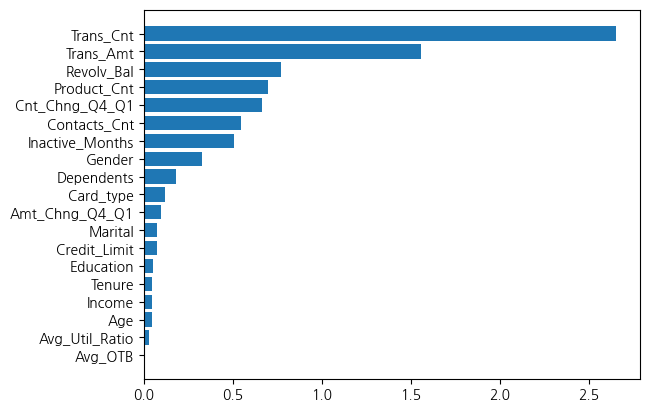

In [24]:
plt.barh(coef_df.sort_values('coef')['feature'], coef_df.sort_values('coef')['coef'])
plt.show();

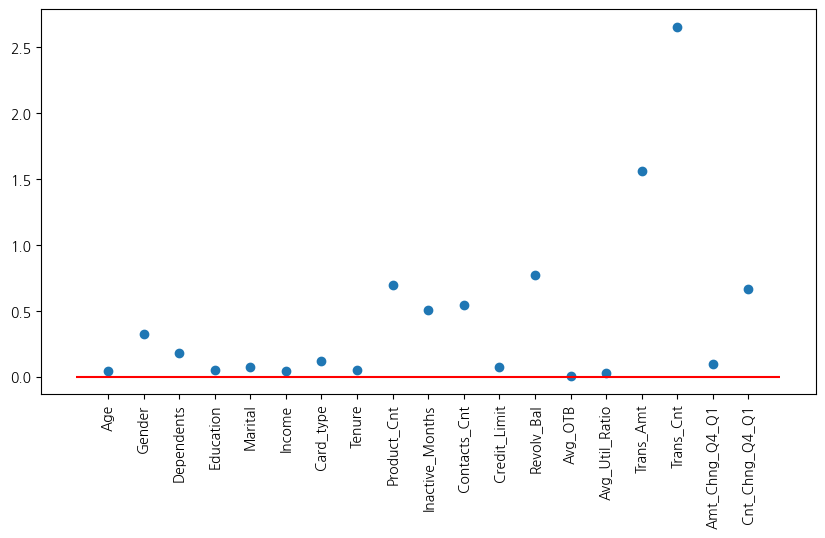

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(coef_df['feature'], coef_df['coef'])
plt.xticks(rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1], 'r')
plt.show();

- Product_Cnt / Inactive_Months / Contacts_Cnt / Revolv_Bal / Trans_Amt / Trans_Cnt / Cnt_Chng_Q4_Q1

---

> ### GridsearchCV를 통한 하이퍼파라미터

In [27]:
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
lr = LogisticRegression(solver='liblinear', random_state=13)

# 탐색할 하이퍼파라미터들의 후보 값들
params = {
    'C': [0.1, 1, 3, 5, 7, 9, 10],  # C 값 후보
    'penalty': ['l1', 'l2'],  # L1 정규화 또는 L2 정규화 후보
}

# GridSearchCV를 이용하여 모델과 파라미터 후보들을 입력하여 튜닝
gridsearch = GridSearchCV(estimator=lr, param_grid=params, cv=5)
gridsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 정확도 출력
print("Best Hyperparameters: ", gridsearch.best_params_)
print("Best Accuracy: ", gridsearch.best_score_)

Best Hyperparameters:  {'C': 3, 'penalty': 'l1'}
Best Accuracy:  0.8996418153707892


In [28]:
score_df = pd.DataFrame(gridsearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",7,0.898778,0.005860
1,"{'C': 0.1, 'penalty': 'l2'}",13,0.893470,0.005517
2,"{'C': 1, 'penalty': 'l1'}",6,0.899025,0.004362
3,"{'C': 1, 'penalty': 'l2'}",11,0.894581,0.006811
4,"{'C': 3, 'penalty': 'l1'}",1,0.899642,0.003959
5,"{'C': 3, 'penalty': 'l2'}",9,0.895075,0.006907
6,"{'C': 5, 'penalty': 'l1'}",4,0.899518,0.003799
7,"{'C': 5, 'penalty': 'l2'}",14,0.893099,0.004825
8,"{'C': 7, 'penalty': 'l1'}",4,0.899518,0.003799
9,"{'C': 7, 'penalty': 'l2'}",8,0.895815,0.007501


In [29]:
# 최적의 파라미터로 모델평가
best_model = gridsearch.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Auc Score:", roc_auc_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.8914116485686081
Recall: 0.5714285714285714
Precision: 0.704119850187266
Auc Score: 0.7624379156494655
F1 Score: 0.6308724832214765


In [30]:
# 하이퍼 파라미터 적용
model = LogisticRegression(solver='liblinear', random_state=13, C=3, penalty='l1' )
model.fit(X_train, y_train)

feature_list = []
importance_list = []

# 회귀계수 중요도 
for feature, importance in zip(X.columns, np.abs(model.coef_[0])):
    feature_list.append(feature)
    importance_list.append(importance)

feature_importance = pd.DataFrame({
    'feature' : feature_list,  
    'importance' : importance_list})

feature_importance.sort_values('importance', ascending=False)

,feature,importance
8,Cnt_Chng_Q4_Q1,2.758846
1,Inactive_Months,0.506333
2,Contacts_Cnt,0.497408
0,Product_Cnt,0.456091
7,Amt_Chng_Q4_Q1,0.382794
4,Avg_Util_Ratio,0.236576
6,Trans_Cnt,0.108250
3,Revolv_Bal,0.001016
5,Trans_Amt,0.000443


> ### Pipeline을 적용한 모델에 GridSearchCV 적용

In [31]:
X = df[['Product_Cnt', 'Inactive_Months', 'Contacts_Cnt', 'Revolv_Bal', 'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1', 'Cnt_Chng_Q4_Q1']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Pipeline 구성
estimators = [
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='liblinear', random_state=13))
]
pipe = Pipeline(estimators)

# 탐색할 하이퍼파라미터들의 후보 값들
params = {
    'lr__C': [0.1, 0.3, 0.5, 0.7, 1],  # C 값 후보
    'lr__penalty': ['l1', 'l2'],  # L1 정규화 또는 L2 정규화 후보

}

# GridSearchCV를 이용하여 모델과 파라미터 후보들을 입력하여 튜닝
gridsearch = GridSearchCV(estimator=pipe, param_grid=params, cv=5)
gridsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 정확도 출력
print("Best Hyperparameters: ", gridsearch.best_params_)
print("Best Accuracy: ", gridsearch.best_score_)

Best Hyperparameters:  {'lr__C': 0.1, 'lr__penalty': 'l2'}
Best Accuracy:  0.900258946999642


In [32]:
score_df = pd.DataFrame(gridsearch.cv_results_)
score_df[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]

,params,rank_test_score,mean_test_score,std_test_score
0,"{'lr__C': 0.1, 'lr__penalty': 'l1'}",3,0.900012,0.004641
1,"{'lr__C': 0.1, 'lr__penalty': 'l2'}",1,0.900259,0.004733
2,"{'lr__C': 0.3, 'lr__penalty': 'l1'}",6,0.899518,0.004874
3,"{'lr__C': 0.3, 'lr__penalty': 'l2'}",2,0.900135,0.004053
4,"{'lr__C': 0.5, 'lr__penalty': 'l1'}",6,0.899518,0.004617
5,"{'lr__C': 0.5, 'lr__penalty': 'l2'}",4,0.899765,0.004452
6,"{'lr__C': 0.7, 'lr__penalty': 'l1'}",10,0.899148,0.004259
7,"{'lr__C': 0.7, 'lr__penalty': 'l2'}",5,0.899642,0.004637
8,"{'lr__C': 1, 'lr__penalty': 'l1'}",9,0.899271,0.004396
9,"{'lr__C': 1, 'lr__penalty': 'l2'}",8,0.899395,0.004441


In [33]:
# 최적의 파라미터로 모델평가
best_model = gridsearch.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Auc Score:", roc_auc_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.8919052319842053
Recall: 0.5623100303951368
Precision: 0.7115384615384616
Auc Score: 0.759057195515777
F1 Score: 0.6281833616298812


In [34]:
# 하이퍼 파라미터 적용
model = LogisticRegression(solver='liblinear', random_state=13, C=0.1, penalty='l2' )
model.fit(X_train, y_train)

feature_list = []
importance_list = []

# 회귀계수 중요도 
for feature, importance in zip(X.columns, np.abs(model.coef_[0])):
    feature_list.append(feature)
    importance_list.append(importance)

feature_importance = pd.DataFrame({
    'feature' : feature_list,  
    'importance' : importance_list})

feature_importance.sort_values('importance', ascending=False)

,feature,importance
8,Cnt_Chng_Q4_Q1,0.878151
2,Contacts_Cnt,0.711465
1,Inactive_Months,0.604672
0,Product_Cnt,0.273915
6,Trans_Cnt,0.087426
4,Avg_Util_Ratio,0.061898
7,Amt_Chng_Q4_Q1,0.057575
3,Revolv_Bal,0.000849
5,Trans_Amt,0.000362


- 1	Cnt_Chng_Q4_Q1	2.758846
- 2	Inactive_Months	0.506333
- 3	Contacts_Cnt	0.497408
- 4	Product_Cnt	0.456091
- 5	Amt_Chng_Q4_Q1	0.382794
- 6	Avg_Util_Ratio	0.236576
- 7	Trans_Cnt	0.108250
- 8	Revolv_Bal	0.001016
- 9	Trans_Amt	0.000443

> ### 2-3 cross validation

In [35]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
lr = LogisticRegression(solver='liblinear', random_state=13)

print('cross validation accuracy : ', cross_val_score(lr, X, y, scoring=None, cv=skfold))
print('Average of accuracy : ', np.mean(cross_val_score(lr, X, y, scoring=None, cv=skfold)))

cross validation accuracy :  [0.8928924  0.88499506 0.88493827 0.89925926 0.8908642 ]
Average of accuracy :  0.8905898382752611


### 회귀계수를 찾고자 했으나 못찾음

In [36]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

kfold = KFold(n_splits=5, shuffle=True, random_state=13)
lr = LogisticRegression(solver='liblinear', random_state=13)
sc = StandardScaler()

cv_accuracy = []
coefficients = []

for train_idx, test_idx in kfold.split(X):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    lr.fit(X_train_scaled, y_train)
    pred = lr.predict(X_test_scaled)
    cv_accuracy.append(accuracy_score(y_test, pred))

    coefficients.append(lr.coef_[0])

print('StratifiedKFold accuracy : ', cv_accuracy)
print('Average of accuracy : ', np.mean(cv_accuracy))

mean_coefficients = np.mean(coefficients, axis=0)

# 각 특성의 회귀 계수를 출력합니다.
print("Logistic Regression Coefficients:")

feature_list = []
coef_list = []

for feature, importance in zip(X.columns, mean_coefficients):
    feature_list.append(feature)
    coef_list.append(importance)

coef_df = pd.DataFrame({
    'feature' : feature_list,
    'coef' : coef_list
})
coef_df

StratifiedKFold accuracy :  [0.8993089832181639, 0.9067127344521224, 0.9076543209876543, 0.9017283950617284, 0.9017283950617284]
Average of accuracy :  0.9034265657562794
Logistic Regression Coefficients:


,feature,coef
0,Age,-0.043193
1,Gender,0.326034
2,Dependents,0.179129
3,Education,0.051624
4,Marital,-0.076445
5,Income,0.045661
6,Card_type,0.119546
7,Tenure,-0.048105
8,Product_Cnt,-0.697759
9,Inactive_Months,0.505006


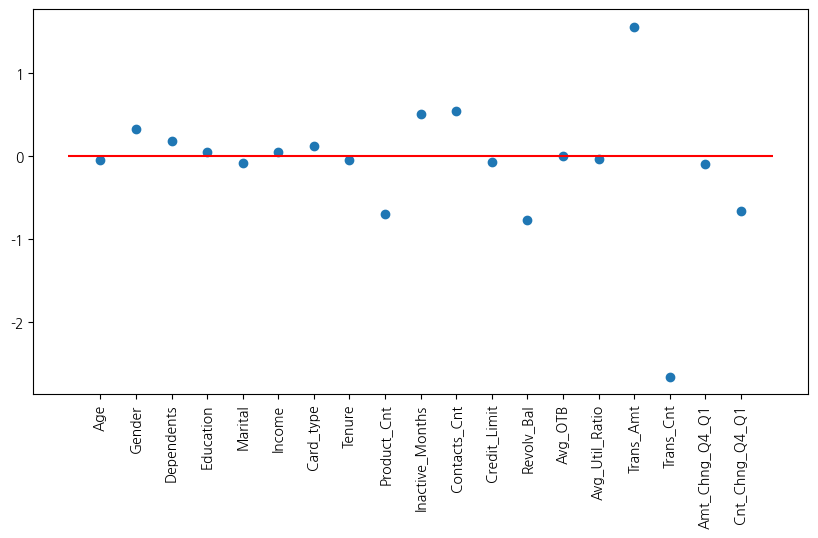

In [37]:
plt.figure(figsize=(10, 5))
plt.scatter(coef_df['feature'], coef_df['coef'])
plt.xticks(rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1], 'r')
plt.show();

- KFold
    - Average of accuracy :  0.9034265657562794
    - Product_Cnt / Inactive_Months / Contacts_Cnt / Revolv_Bal / Trans_Amt / Trans_Cnt / Cnt_Chng_Q4_Q1
- StratifiedKFold 
    - Average of accuracy :  0.9048090380607656
    - Product_Cnt / Inactive_Months / Contacts_Cnt / Revolv_Bal / Trans_Amt / Trans_Cnt / Cnt_Chng_Q4_Q1
- Cross-Validation
    - Average of accuracy :  0.8909835837812146

> ### saga
- 확률적경사하강법을 기반으로 하며 대용량 데이터에 적합한 알고리즘
- sag는 L1 제약조건만을 지원, saga는 L1, L2 제약조건 둘 다 지원

In [38]:
# # 라벨 분류
# X = df.drop(['Exited'], axis=1)
# y = df['Exited']

# # 훈련용 / 테스트용 데이터 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13) 

# # Logistic Regression
# lr = LogisticRegression(solver='saga', random_state=13, max_iter=10000)

# lr.fit(X_train, y_train)

# y_pred_tr = lr.predict(X_train)
# y_pred_test = lr.predict(X_test)

# coefficients = lr.coef_[0]
# intercept = lr.intercept_[0]

# print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
# print('Test Acc : ', accuracy_score(y_test, y_pred_test))

# print("회귀 계수:")
# for feature, coef in zip(X.columns, coefficients):
#     print(f"{feature}: {coef}")

# print(f"절편: {intercept}")

In [39]:
# print(classification_report(y_test, lr.predict(X_test)))

> ### lbfgs
- newton-cg, lbfgs는 멀티클래스의 분류 모델에 쓰임 / L2 제약조건만 지원
- 현재까지는 lbfgs 알고리즘 성능이 가장 좋다고 알려짐

In [40]:
# # 라벨 분류
# X = df.drop(['Exited'], axis=1)
# y = df['Exited']

# # 훈련용 / 테스트용 데이터 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13) 

# # Logistic Regression
# lr = LogisticRegression(solver='lbfgs', random_state=1, max_iter=250)

# lr.fit(X_train, y_train)

# y_pred_tr = lr.predict(X_train)
# y_pred_test = lr.predict(X_test)

# coefficients = lr.coef_[0]
# intercept = lr.intercept_[0]

# print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
# print('Test Acc : ', accuracy_score(y_test, y_pred_test))

# print("회귀 계수:")
# for feature, coef in zip(X.columns, coefficients):
#     print(f"{feature}: {coef}")

# print(f"절편: {intercept}")

- max_iter는 Gradient Descent 방식을 반복해서 몇번 수행할 것인가 인데, 
이게 일단 수렴(Convergence)하게 되면 횟수를 늘려도 성능이 거의 달라지지 않는다.

In [41]:
# print(classification_report(y_test, lr.predict(X_test)))

> ## 정리
- liblinear
    - Train Acc :  0.8959387729909888
    - Test Acc :  0.8928923988153998

- saga
    - Train Acc :  0.846932477471917
    - Test Acc :  0.8469891411648569

- lbfgs
    - Train Acc :  0.8914948771756573
    - Test Acc :  0.8830207305034551

> ### 회귀계수, standardscaler하고 feature 비교

- 회귀계수 양수는 Gender, Contacts_Cnt, Inactive_Months, Dependents, Card_type
- 회귀계수 음수는 Cnt_Chng_Q4_Q1, Product_Cnt, Amt_Chng_Q4_Q1, Trans_Cnt, Marital
- 회귀계수 절대값 크기 Cnt_Chng_Q4_Q1, Gender, Contacts_Cnt, Inactive_Months, Product_Cnt, Dependents, Amt_Chng_Q4_Q1

- feature 양수는 Trans_Amt, Contacts_Cnt, Inactive_Months, Gender
- feature 음수는 Trans_Cnt, Revolv_Bal, Product_Cnt, Cnt_Chng_Q4_Q1
- Trans_Amt, Trans_Cnt, Revolv_Bal, Product_Cnt, Cnt_Chng_Q4_Q1 이 큰 영향을 미친다?

### Decision Tree

In [42]:
# # 라벨 분류
# X = df.drop(['Exited'], axis=1)
# y = df['Exited']

# # 훈련용 / 테스트용 데이터 나누기
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13) 

# # Decision Tree Train
# exited_tree = DecisionTreeClassifier(max_depth=3, random_state=13)
# exited_tree.fit(X_train, y_train)

# y_pred_tr = exited_tree.predict(X_train)
# y_pred_test = exited_tree.predict(X_test)

# print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
# print('Test Acc : ', accuracy_score(y_test, y_pred_test))


In [43]:
# plt.figure(figsize=(12, 8))
# tree.plot_tree(exited_tree, feature_names=X.columns,
#                rounded=True,
#                filled=True)
# plt.show()

- Trans_Amt, Revolv_Bal, Trans_Amt, Product_Cnt, Trans_Cnt

C:\Users\gks76\AppData\Local\Temp\ipykernel_8124\1476449625.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


<Axes: xlabel='Exited', ylabel='Revolv_Bal'>

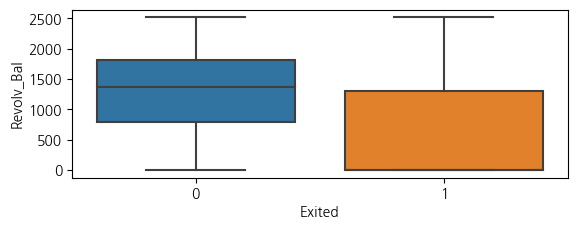

In [44]:
plt.subplot(1,2,1)
sns.boxplot(data= df, y='Product_Cnt', x= 'Exited')

plt.subplot(1,2,2)
sns.boxplot(data= df, y='Inactive_Months', x= 'Exited')

plt.subplot(2,1,1)
sns.boxplot(data= df, y='Revolv_Bal', x= 'Exited')

In [45]:
df.columns

Index(['Exited', 'Age', 'Gender', 'Dependents', 'Education', 'Marital',
       'Income', 'Card_type', 'Tenure', 'Product_Cnt', 'Inactive_Months',
       'Contacts_Cnt', 'Credit_Limit', 'Revolv_Bal', 'Avg_OTB',
       'Avg_Util_Ratio', 'Trans_Amt', 'Trans_Cnt', 'Amt_Chng_Q4_Q1',
       'Cnt_Chng_Q4_Q1'],
      dtype='object')